In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint, random, seed
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report

In [2]:
TRAIN_PATH = 'dataset/train1x5.csv'
TEST_PATH = 'dataset/test1x5.csv'

train_redu = pd.read_csv('dataset/train_redu.csv')
test_redu = pd.read_csv('dataset/test_redu.csv')

Construindo vetores

In [3]:
X_train = [(x,y) for x, y in zip(train_redu['intensidade'], train_redu['simetria'])]
y_train = train_redu['label']

X_test = [(x,y) for x, y in zip(test_redu['intensidade'], test_redu['simetria'])]
y_test = test_redu['label']

# Perceptron 

- Tem que ser max_iter = n de pontos
- Guardar a melhor solução
- w pode comecar com 0 ou random

A linha de decisão é dada pela equação: $w_1x_1+w_2x_2+b=0$, onde $w_1 e w_2$​ são os pesos e b é o viés.

$h(x) = sign(w^Tx)$

$w=w+y_ix_i$

In [4]:
class PocketPla():
    def __init__(self,max_iter):
        self.max_iter = max_iter
        self.best_w = None
        self.best_eIN = None
        self.iterations = 0


    def constroiListaPCI(self,X,y,w):
        listaPCI = [i for i in range(len(X)) if np.sign(np.dot(X[i], w)) != y[i]]
        return listaPCI
    
    def predict(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        return np.sign(np.dot(X, self.best_w))
    
    def getW(self): 
        return self.best_w
    
    def h(self, x): # função de ativação
        x = np.column_stack((np.ones(len(x)), x))
        return np.sign(np.dot(self.best_w, x))
    
    def getOriginalY(self, originalX):
        return (-self.best_w[0] - self.best_w[1]*originalX) / self.best_w[2]
    
    def getIterations(self):
        return self.iterations
    
    def getBestEin(self,X):
        return self.best_eIN

    def fit(self, X, y):
        X = np.column_stack((np.ones(len(X)), X))
        w = [0,0,0]
        self.best_w = w.copy()

        for _ in range(self.max_iter):
            self.iterations += 1
            listaPCI = self.constroiListaPCI(X,y,w)

            if len(listaPCI) == 0:
                break

            i = np.random.choice(listaPCI) # escolhe um índice aleatório da lista PCI
            w = w + y[i]*X[i] # atualizaÇÃO do vetor de pesos
            error_count = len(self.constroiListaPCI(X,y,w))/X.shape[0] # calcula o erro de classificação

            if self.best_eIN is None or error_count < self.best_eIN:
                self.best_eIN = error_count
                self.best_w = w
    
        return self

In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
y_train_transformed = np.where(y_train == 0, 1, -1) # transformando 1 em 1 e 5 em -1
n = X_train.shape[0]
PLA = PocketPla(n)
PLA.fit(X_train, y_train_transformed)
w = PLA.getW()
w


array([-264.        ,  856.57647059, -866.44705882])

In [6]:
y_train_transformed

array([ 1,  1,  1, ..., -1, -1, -1])

In [7]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test_transformed = np.where(y_test == 0, 1, -1) # 1 onde é 0 e -1 onde é 5
y_pred = PLA.predict(X_test)
#y_pred

In [8]:
accuracy = np.mean(y_pred == y_test_transformed)
accuracy

0.8394618834080717

In [9]:
ein = PLA.getBestEin(X_train)
eout = np.mean(y_pred != y_test_transformed)

print(f'Ein: {ein:.2f}')
print(f'Eout: {eout:.2f}')

Ein: 0.16
Eout: 0.16


In [10]:
print(classification_report(y_test_transformed, y_pred))

              precision    recall  f1-score   support

          -1       0.86      0.96      0.91       897
           1       0.67      0.36      0.47       218

    accuracy                           0.84      1115
   macro avg       0.76      0.66      0.69      1115
weighted avg       0.82      0.84      0.82      1115



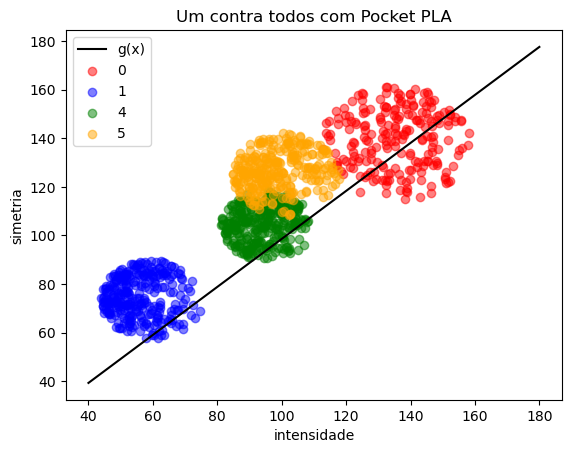

In [11]:
label_0 = test_redu[test_redu['label'] == 0]
label_others = test_redu[test_redu['label'] != 0]


xOri = [40, 180]
yOri = [PLA.getOriginalY(xOri[0]), PLA.getOriginalY(xOri[1])]
plt.plot(xOri, yOri, label='g(x)',color='black')
plt.scatter(label_0['intensidade'], label_0['simetria'],color='red', label='0', alpha=0.5)
plt.scatter(label_others['intensidade'], label_others['simetria'],color='blue', label='1', alpha=0.5)
plt.xlabel('intensidade')
plt.ylabel('simetria')
plt.title('Um contra todos com Pocket PLA')
plt.legend()
plt.show()


Linear Regression

vetor de pesos $w=(X^TX)^{-1}X^Ty$

In [12]:
class LinearRegression():
    def __init__(self):
        self.w = None

    def getW(self):
        return self.w
    
    def fit(self, _X, _y):
        s = _X.shape[0]
        X = np.column_stack((np.ones(s), _X))
        self.w = np.linalg.inv(X.T @ X) @ X.T @ _y
        return self
    
    def predict(self, _X):
        if self.w is None:
            raise Exception('Modelo não treinado')
        s = _X.shape[0]
        X = np.column_stack((np.ones(s), _X))
        return X @ self.w
    

class LRClassifier():
    def execute(self, _X, _y):
        lr = LinearRegression()
        lr.fit(_X, _y)
        self.w = lr.getW()
                
    def predict(self, x_):
        return np.sign(np.dot(np.insert(x_, 0, 1,axis=1), self.w))
     
    def getRegressionY(self, regressionX, shift=0):
        return (-self.w[0]+shift - self.w[1]*regressionX) / self.w[2]

In [13]:
lrc = LRClassifier()
lrc.execute(X_train, y_train_transformed)
w = lrc.w
predictions = lrc.predict(X_test)
accuracy = np.mean(predictions == y_test_transformed)
accuracy

0.9605381165919282

In [14]:
print(classification_report(y_test_transformed, predictions))

              precision    recall  f1-score   support

          -1       0.95      1.00      0.98       897
           1       1.00      0.80      0.89       218

    accuracy                           0.96      1115
   macro avg       0.98      0.90      0.93      1115
weighted avg       0.96      0.96      0.96      1115



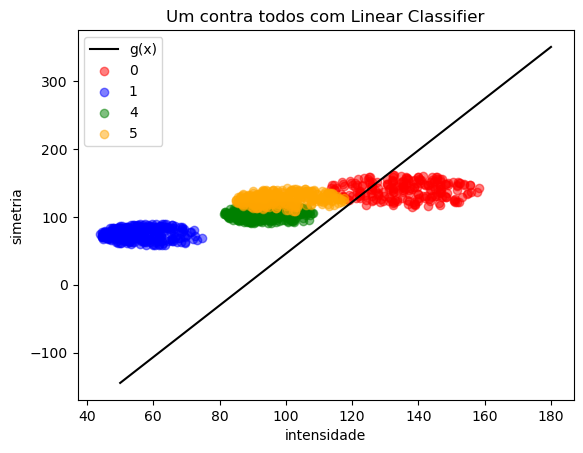

In [15]:
xOri = [50, 180]
yOri = [lrc.getRegressionY(xOri[0]), lrc.getRegressionY(xOri[1])]
plt.plot(xOri, yOri, label='g(x)',color='black')
plt.scatter(label_0['intensidade'], label_0['simetria'],color='red', label='0', alpha=0.5)
plt.scatter(label_1['intensidade'], label_1['simetria'],color='blue', label='1', alpha=0.5)
plt.scatter(label_4['intensidade'], label_4['simetria'],color='g', label='4', alpha=0.5)
plt.scatter(label_5['intensidade'], label_5['simetria'],color='orange', label='5', alpha=0.5)
plt.xlabel('intensidade')
plt.ylabel('simetria')
plt.title('Um contra todos com Linear Classifier')
plt.legend()
plt.show()

1 para todos